In [1]:
from pathlib import Path

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interpolate

import project_path
import nn.utils as utils
import nn.model.net as net
import nn.model.data as data
import nn.model.loss as loss

## Constants

In [6]:
NUM_CLASSES = 5
CLASSES = ['Gluon', 'Lght quarks', 'W boson', 'Z boson', 'Top quark']
MODEL_DIR = Path("../../../experiments/pre_train/constituent_perceiver_32_16/best.script.pth")

In [7]:
torch.manual_seed(230)

## Data

In [8]:
# (1) creating dataset
datasets = data.get_dataset(splits=['train-val', 'test'])
dataset = datasets['train-val']
test_set = datasets['test']

# (2) train-validation split
dataset_size = len(dataset)
train_set, val_set, _ = torch.utils.data.random_split(dataset, [dataset_size - 1000, 1000, 0])

# (3) train-validation dataloaders
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=data.get_collate_fn())
val_loader = data.DataLoader(val_set, batch_size=32, collate_fn=data.get_collate_fn())
test_loader = data.DataLoader(test_set, batch_size=32, collate_fn=data.get_collate_fn())

In [10]:
utils.count_parameters(model.out_layer)

132613

In [11]:
utils.count_parameters(model.out_layer) / utils.count_parameters(model)

0.8870850140140341

## Model

In [9]:
model = torch.jit.load(MODEL_DIR, map_location='cpu')
print(f'Number of parameters: {utils.count_parameters(model)}')
model.eval()

Number of parameters: 149493


RecursiveScriptModule(
  original_name=ConstituentNetPerceiver
  (perceivers): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Perceiver
      (cross_transformer): RecursiveScriptModule(
        original_name=CrossTransformer
        (self_attention): RecursiveScriptModule(
          original_name=SelfAttention
          (norm): RecursiveScriptModule(original_name=LayerNorm)
          (qkv): RecursiveScriptModule(original_name=Linear)
          (out): RecursiveScriptModule(original_name=Linear)
        )
        (cross_attention): RecursiveScriptModule(
          original_name=Attention
          (norm): RecursiveScriptModule(original_name=LayerNorm)
          (queries): RecursiveScriptModule(original_name=Linear)
          (keys): RecursiveScriptModule(original_name=Linear)
          (values): RecursiveScriptModule(original_name=Linear)
          (out): RecursiveScriptModule(original_name=Linear)
        )
        (linear): Recur

## Evaluation

In [6]:
# Statistics summary
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(val_loader), unit="batch") as t:
    for i, batch in enumerate(val_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs, energy = model(input_seqs)                 # torch.tensor (n, num_classes)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:10<00:00,  2.21s/batch]


### Confusion Matrix

Accuracy:  0.818


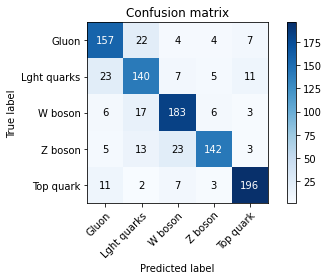

In [7]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, precision,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### ROC

In [8]:
# Stack a list of ndarray
y_test = np.vstack([utils.one_hot(targs, NUM_CLASSES) for targs in targs_list])
y_score = np.vstack(outs_list)

# Compute ROC curve and ROC area for each class
fprs = dict()
tprs = dict()
roc_aucs = dict()
for i in range(NUM_CLASSES):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_aucs[i] = auc(fprs[i], tprs[i])

# Compute micro-average of all classes ROC curve and ROC area
fprs["micro"], tprs["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_aucs["micro"] = auc(fprs["micro"], tprs["micro"])

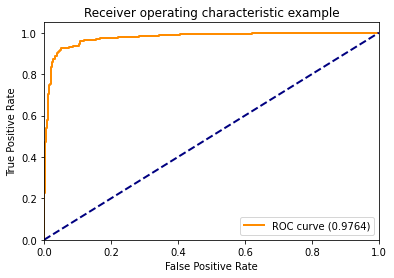

In [9]:
plt.figure()
plt.plot(fprs[4], tprs[4], color='darkorange', lw=2, label=f'ROC curve ({roc_aucs[4]:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
print('TPR for FPR = 10%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.1):<15}')

print()
print('TPR for FPR = 1%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.01):<15}')

TPR for FPR = 10%
 Gluon:       0.845360824742268
 Lght quarks: 0.8387096774193549
 W boson:     0.9209302325581395
 Z boson:     0.8548387096774194
 Top quark:   0.9360730593607306

TPR for FPR = 1%
 Gluon:       0.5154639175257731
 Lght quarks: 0.26881720430107525
 W boson:     0.5023255813953489
 Z boson:     0.6881720430107527
 Top quark:   0.5799086757990868


## Test

In [11]:
# Statistics summary
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(test_loader), unit="batch") as t:
    for i, batch in enumerate(test_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs, energy = model(input_seqs)                 # torch.tensor (n, num_classes)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:59<00:00,  2.62batch/s]


### Confusion Matrix

Accuracy:  0.7969


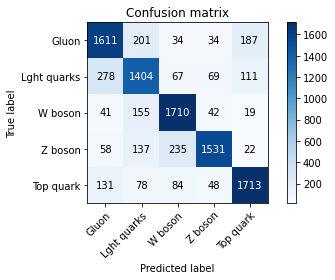

In [16]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, precision,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### ROC

In [13]:
# Stack a list of ndarray
y_test = np.vstack([utils.one_hot(targs, NUM_CLASSES) for targs in targs_list])
y_score = np.vstack(outs_list)

# Compute ROC curve and ROC area for each class
fprs = dict()
tprs = dict()
roc_aucs = dict()
for i in range(NUM_CLASSES):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_aucs[i] = auc(fprs[i], tprs[i])

# Compute micro-average of all classes ROC curve and ROC area
fprs["micro"], tprs["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_aucs["micro"] = auc(fprs["micro"], tprs["micro"])

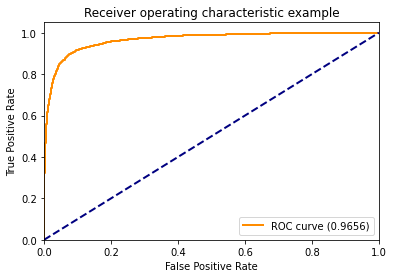

In [14]:
plt.figure()
plt.plot(fprs[4], tprs[4], color='darkorange', lw=2, label=f'ROC curve ({roc_aucs[4]:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [15]:
print('TPR for FPR = 10%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.1):<15}')

print()
print('TPR for FPR = 1%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.01):<15}')

TPR for FPR = 10%
 Gluon:       0.8543783260764393
 Lght quarks: 0.7936754795230689
 W boson:     0.922216573462125
 Z boson:     0.8658598083711548
 Top quark:   0.9162609542356378

TPR for FPR = 1%
 Gluon:       0.444121915820029
 Lght quarks: 0.27319854847071023
 W boson:     0.5709201830198272
 Z boson:     0.7034795763993948
 Top quark:   0.617332035053554
